In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

from sklearn import cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

%matplotlib inline

<h1> Feature Selection

In [2]:
data = pd.read_csv('../data/Project_Data.csv')
# Subset county data for future analysis
county = data[['State','County', 'num_competitor', 'MF_exist', 'nm_MF']]
X_columns = ['POPESTIMATE', 'POPESTIMATE_rate', 'AGE5_40ToT_rate', 'X..Adults.with.Obesity',
       'Food.Environment.Index', 'X80th.Percentile.Income',
       'X20th.Percentile.Income', 'Income.Ratio','Trade_2020',
       'Employment.Location.Quotient.Relative.to.U.S._1',
       'Asian', 'num_competitor', 'nm_MF', 'LABEL_bubbleStore_cnt',
       'Num_Starbucks', 'Num_Teavana', 'college_cnt',
       'costco_count', 'income_median', 'pop_asian',
       'pop_belowPovertyThreshold', 'pop_black', 'pop_density','pop_foreignBorn',
       'pop_latino','rating', 'review count',
       'selfstorage_area', 'selfstorage_count', 'shopping_mall_cnt',
       'walmart_cnt']

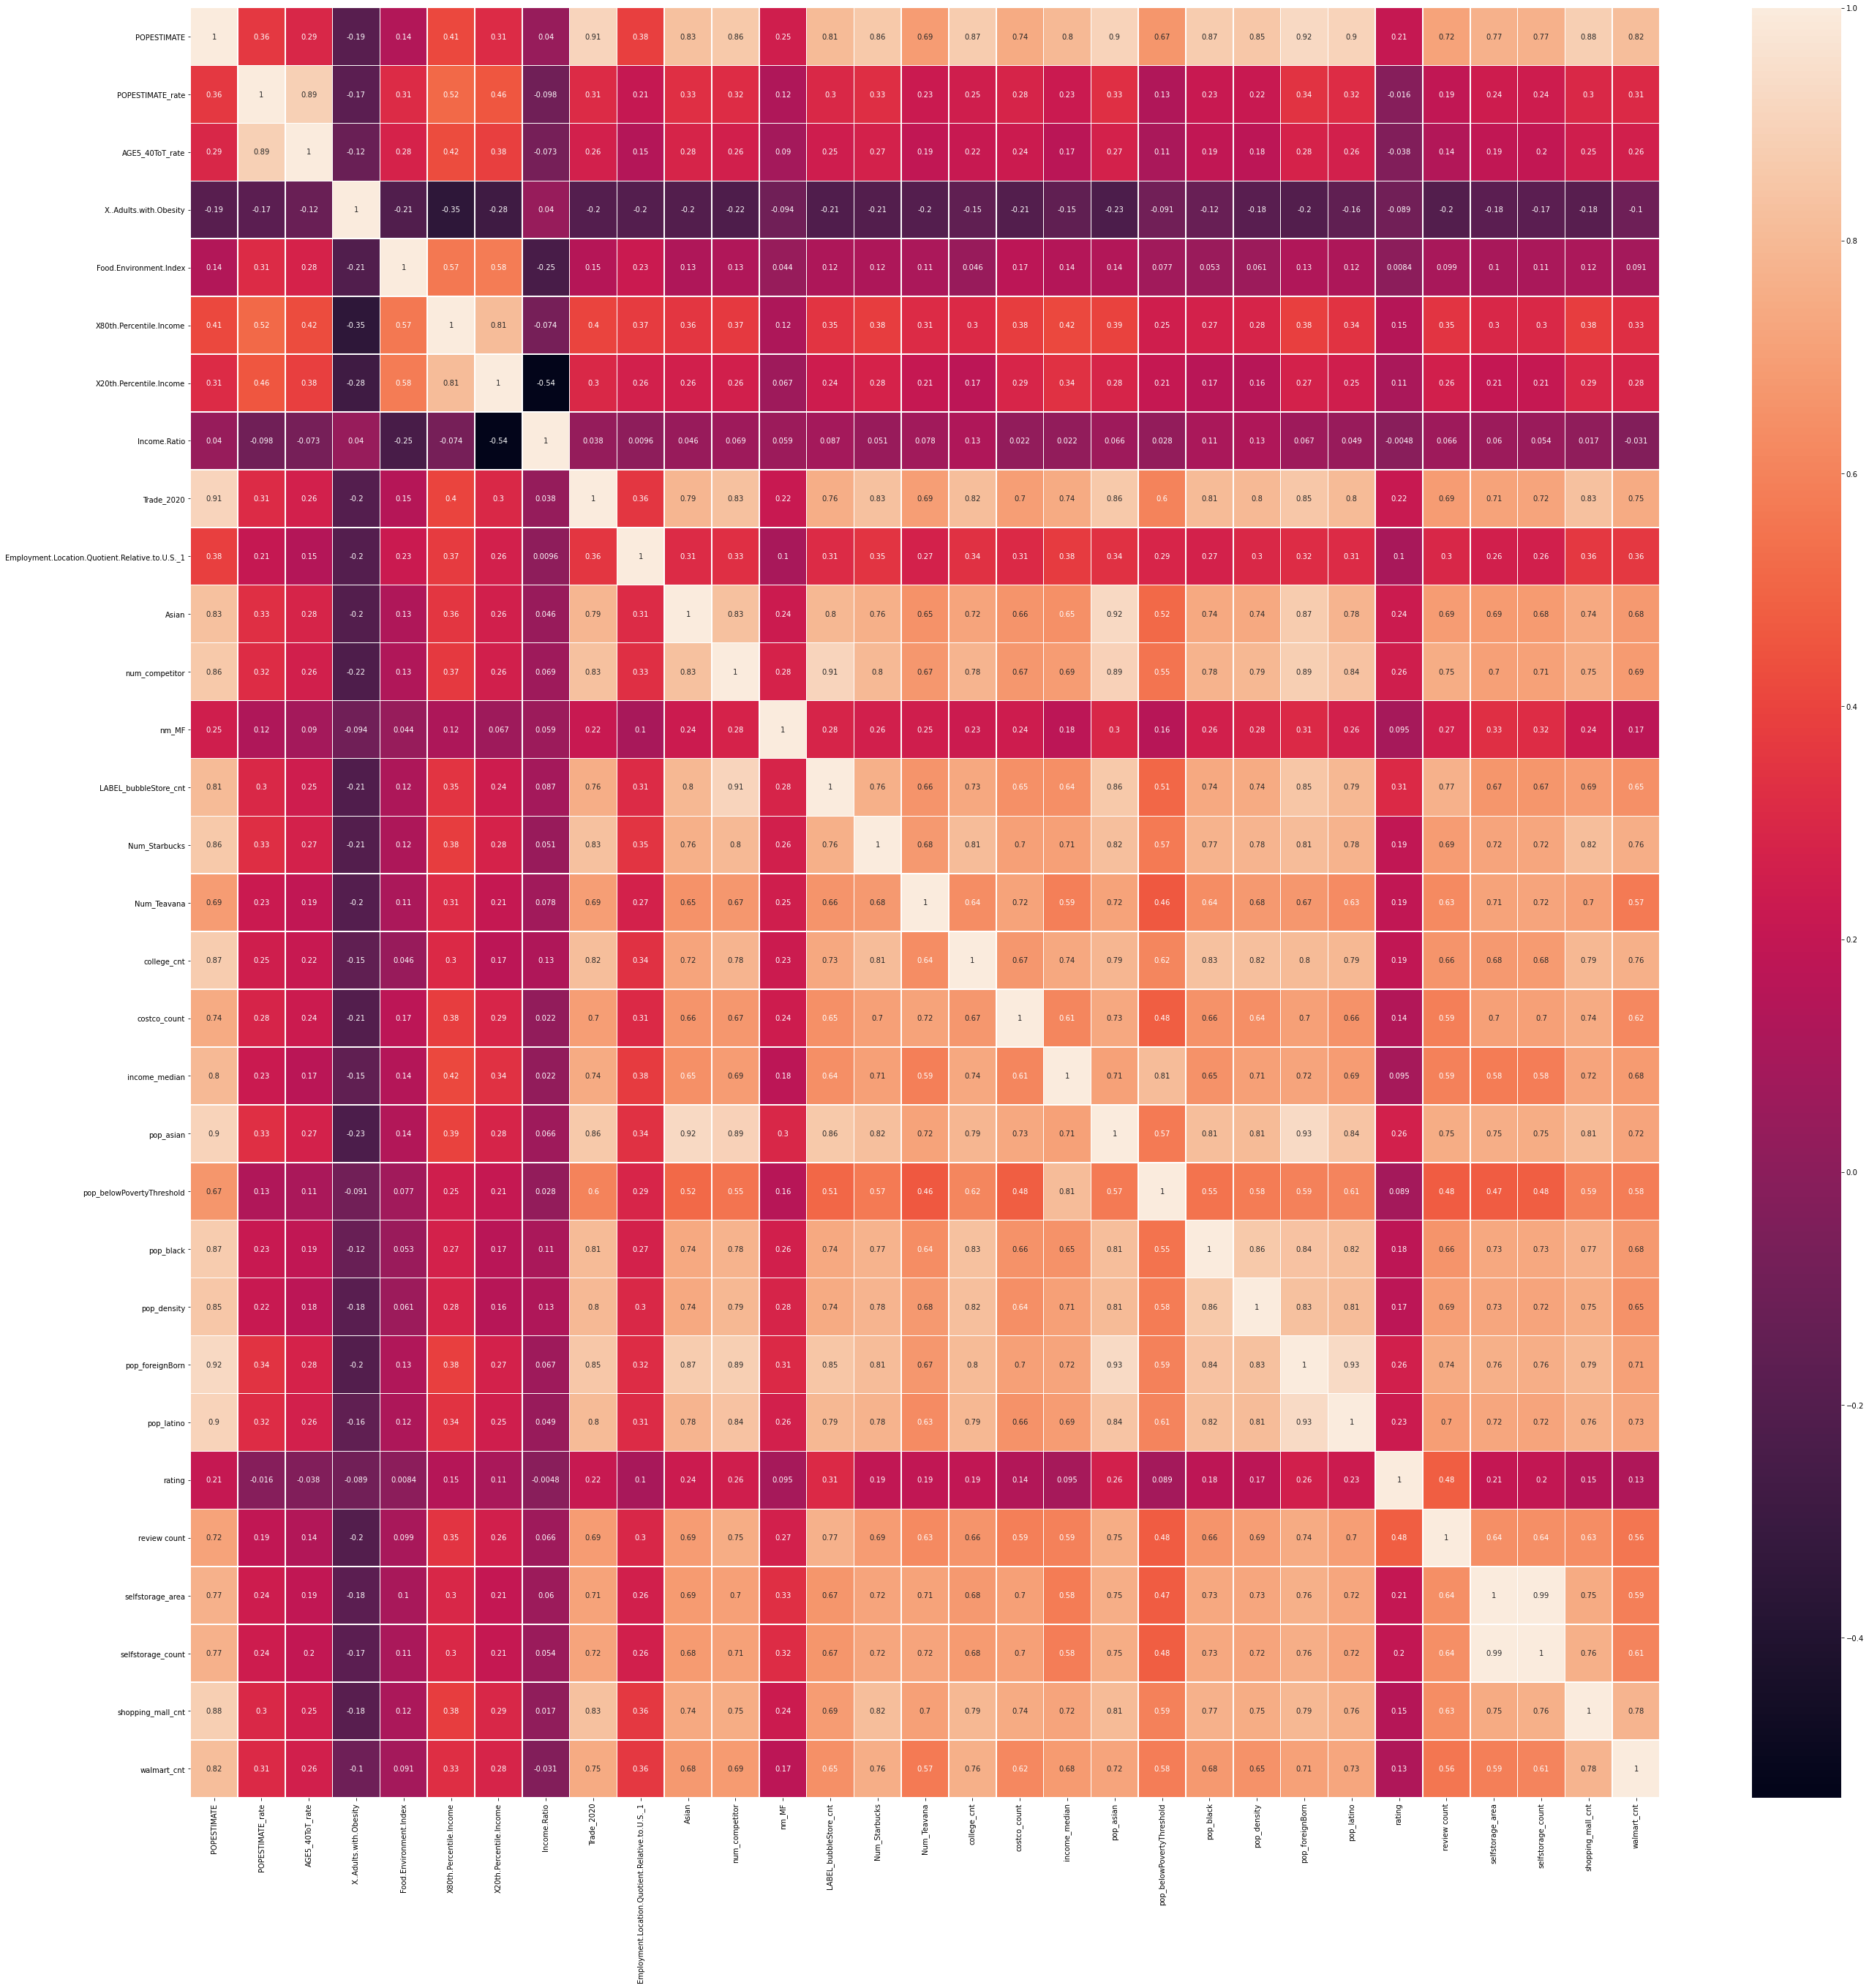

In [4]:
def feature_selection_plot(data, X_columns):
    data_nor = data.groupby('State').transform(lambda x : (x - x.min()) / (x.max() - x.min()))
    X_data = data_nor[X_columns]
    X_data = X_data.fillna(0)
    y_data = data['MF_exist']
    fig, ax = plt.subplots(figsize=(45,45))
    hm = sns.heatmap(X_data.corr(), annot = True, linewidths=.5, ax=ax)
    #plt.savefig("Plotting_Correlation_HeatMap_nor.jpg")
    plt.show()
feature_selection_plot(data, X_columns)

In [5]:
def KB_CF_scores(X_columns, data):
    data_nor = data.groupby('State').transform(lambda x : (x - x.min()) / (x.max() - x.min()))
    X_data = data_nor[X_columns]
    X_data = X_data.fillna(0)
    y_data = data['MF_exist']
    KB_CF = SelectKBest(f_classif, k=15)
    KB_CF.fit(X_data, y_data)
    return KB_CF


In [6]:
def SelectName(KB):
    
    threshold = sorted(KB.scores_, reverse=True)[KB.k - 1]
    
    col_names = []

    for score, col in zip(KB.scores_, X_columns):
        if score >= threshold:
            col_names.append(col)
            
    return col_names

KB_CF = KB_CF_scores(X_columns, data)
#SelectName(KB_CF)

In [7]:
def SelectName_P(P_val, KB):

    col_names = []
    
    for pvalues, cols in zip(KB.pvalues_, X_columns):
        if pvalues <= P_val:
            col_names.append(cols)
            
    return col_names
#SelectName_P(0.01, KB_CF)

In [8]:
# Select reliable features based on the feature selection results 
selected_cols = ['State',
                  'POPESTIMATE',
                  'X..Adults.with.Obesity',
                  'Trade_2020',
                  'Employment.Location.Quotient.Relative.to.U.S._1',
                  'Asian',
                  'num_competitor',
                  'college_cnt',
                  'income_median',
                  'pop_belowPovertyThreshold',
                  'selfstorage_count',
                  'shopping_mall_cnt']

In [10]:
def features_for_clustering(selected_cols, data):
    select_data = data[selected_cols]
    # Normalize the data based on State level to eliminate the big differences between each States
    select_data_nor = select_data.groupby('State').transform(lambda x : (x - x.min())/(x.max()-x.min()))
    # Create two new dataset which are identified as original data and normalized data
    before = select_data.drop(columns='State')
    after = select_data_nor

    # Change the column names of normalized data
    after.columns = ['POPESTIMATE_nor',
                    'X..Adults.with.Obesity_nor',
                    'Trade_2020_nor',
                    'Employment.Location.Quotient.Relative.to.U.S._1_nor',
                    'Asian_nor',
                    'num_competitor_nor',
                    'college_cnt_nor',
                    'income_median_nor',
                    'pop_belowPovertyThreshold_nor',
                    'selfstorage_count_nor',
                    'shopping_mall_cnt_nor']
    # Combine two dataset as one and replace the NAN values as zero. The new dataset will be used for further processing
    cluster_data = pd.concat([before, after], axis=1)
    cluster_data.fillna(value = 0, inplace = True)
    return cluster_data


<h1> Model

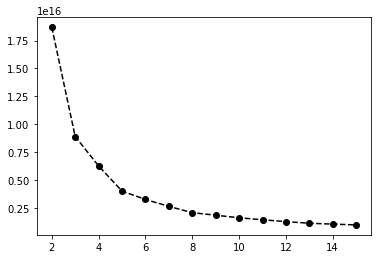

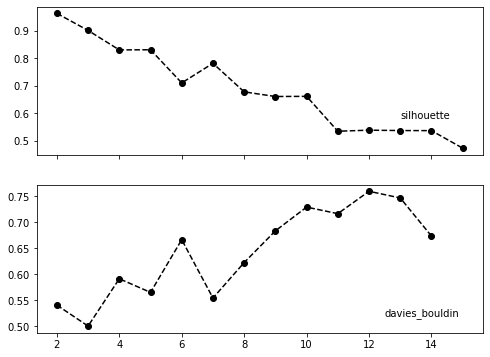

In [9]:
def search_kmeans(cluster_data):
    # Search the suitable cluster numbers for K-Means
    clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    inertias = []
    
    for c in clusters_range:
        kmeans = KMeans(init='k-means++', n_clusters=c, n_init=c,random_state=0).fit(cluster_data)    
        inertias.append(kmeans.inertia_)

    plt.figure()
    plt.plot(clusters_range,inertias,'ko--')
    plt.show()
    # Using Silhouette and Davies_Bouldin scores to verify the cluster numbers for K-Means
    sil = []
    for c in clusters_range:
        kmeans = KMeans(init="k-means++", n_clusters=c, n_init=c, random_state=0).fit(cluster_data)
        predicted_labels = kmeans.labels_
        sil.append(silhouette_score(cluster_data, predicted_labels, metric = 'euclidean'))
        
    davies = []
    for c in range(2,15):
        kmeans = KMeans(init="k-means++", n_clusters=c, n_init=c).fit(cluster_data)
        predicted_labels = kmeans.labels_
        davies.append(davies_bouldin_score(cluster_data, predicted_labels))
    # Plot the scores
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex = True)

    ax1.plot(clusters_range, sil, 'ko--')
    ax1.text(13, 0.58, 'silhouette')
    ax2.plot([i for i in range(2,15)], davies, 'ko--')
    ax2.text(12.5, 0.52, 'davies_bouldin')

    #fig.savefig('Score.jpg', dpi=600)
cluster_data = features_for_kmeans(selected_cols, data)
search_kmeans(cluster_data)

In [10]:
def kmeans_model(cluster_data):
    kmeans_sel = KMeans(n_clusters=2).fit(cluster_data)
    km_labels = pd.DataFrame(kmeans_sel.labels_)
    km_clustered_data = cluster_data.assign(Clusters = km_labels)
    grouped_km = km_clustered_data.groupby(['Clusters']).mean().round(1)
    km_county_cluster = county.assign(Clusters = km_labels)
    km_cluster_0 = km_county_cluster[km_county_cluster['Clusters']==0]
    km_cluster_1 = km_county_cluster[km_county_cluster['Clusters']==1]
    print(km_cluster_0.shape[0])
    print(km_cluster_1.shape[0])
    print(len(km_cluster_0[km_cluster_0['MF_exist'] == 1]))
    print(len(km_cluster_1[km_cluster_1['MF_exist'] == 1]))
kmeans_model(cluster_data)

3077
10
14
7


<h1> DBSCAN

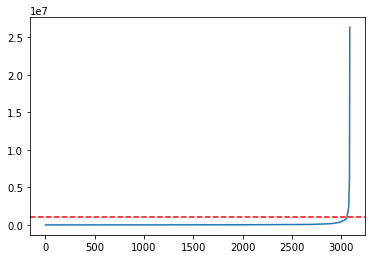

In [11]:
def optimal_params(cluster_data):
    # Using nearestneighbors to find the optimal parameters for eps
    neighbors = NearestNeighbors(n_neighbors=15)
    neighbors_fit = neighbors.fit(cluster_data)
    distances, indices = neighbors_fit.kneighbors(cluster_data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.axhline(y = 0.1*1e7, color = 'r', linestyle = 'dashed')
    #plt.savefig('eps.jpg', dpi=600)
    plt.show()
cluster_data = features_for_clustering(selected_cols, data)
optimal_params(cluster_data)

In [12]:
def dbscan(cluster_data):
    # Using DBSACN to fit the data
    dbs = cluster.DBSCAN(eps=0.1*1e7, min_samples=15)
    dbs.fit(cluster_data)
    # Display the results of DBSCAN using average values
    db_labels = pd.DataFrame(dbs.labels_)
    db_clustered_data = cluster_data.assign(Clusters = db_labels)
    grouped_db = db_clustered_data.groupby(['Clusters']).mean().round(1)
    # Subset the cluster dataset
    db_county_cluster = county.assign(Clusters = db_labels)
    db_cluster_0 = db_county_cluster[db_county_cluster['Clusters']==-1]
    db_cluster_1 = db_county_cluster[db_county_cluster['Clusters']==0]
    # Display the results
    print(db_cluster_0.shape[0])
    print(db_cluster_1.shape[0])
    print(len(db_cluster_0[db_cluster_0['MF_exist'] == 1]))
    print(len(db_cluster_1[db_cluster_1['MF_exist'] == 1]))
    Final_cluster = db_clustered_data
    Final_cluster["State"] = db_county_cluster["State"]
    Final_cluster["County"] = db_county_cluster["County"]
    Final_cluster["MF_exist"] = db_county_cluster["MF_exist"]
    Final_cluster["nm_MF"] = db_county_cluster["nm_MF"]
    #Final_cluster.to_csv('../data/Final_cluster.csv')
    return Final_cluster

Final_cluster = dbscan(cluster_data)


91
2996
17
4


<h1> Calculate weights

In [31]:
weight = pd.read_csv("../data/MF_NmOfComments_AvgNote.csv")

In [32]:
def cal_weights(weight, cluster_data):
    # Calculate the weight based on the number of comments
    review_sum = weight['review count'].sum()
    weight['weight'] = weight['review count'].transform(lambda x : x/review_sum)
    # Merge the weight into original data
    weight_data = pd.merge(data, weight, how ="left", left_on = 'FIPS', right_on='county_fips')
    weight_data = weight_data[weight_data['weight'].notna()]
    weight = weight_data['weight']
    # Add weight into cluster data
    benchmark_base = cluster_data.copy()
    benchmark_base['weight'] = weight
    benchmark_base = benchmark_base.dropna()
    benchmark_max = benchmark_base.loc[benchmark_base['weight'].idxmax(),:]
    return benchmark_base, benchmark_max

In [33]:
benchmark_base, benchmark_max = cal_weights(weight, cluster_data)

100%|██████████| 3087/3087 [00:00<00:00, 4411.37it/s]


4.144870152332954
4.004888509199092
3.7802007071452013
0.0


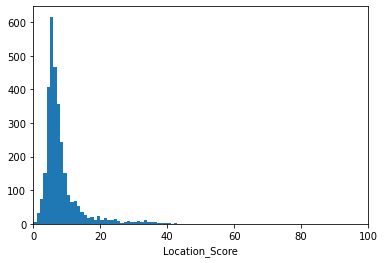

In [35]:
def cal_distance(cluster_data, benchmark_max):
    data_for_dis = cluster_data.copy()
    data_for_dis.loc['benchmark_avg', :] = benchmark_max

    # Normalize the data before calculation
    data_for_dis = data_for_dis.transform(lambda x : (x - x.min())/(x.max()-x.min()))
    # Calculate the distance using 2-norm metrics
    from tqdm import tqdm
    distance = []
    for i in tqdm(range(3087)):
        dis = np.linalg.norm(data_for_dis.loc[i,:]-data_for_dis.loc['benchmark_avg', :],ord=2)
        distance.append(dis)
    cluster_data['distance'] = distance
    print(cluster_data['distance'].max())
    print(cluster_data['distance'].quantile(0.95))
    print(cluster_data['distance'].quantile(0.25))
    print(cluster_data['distance'].min())
        # Set the quantile as 0.95, the smaller distance is more suitable for store location
    cluster_data['location_score'] = cluster_data['distance'].transform(lambda x : (x.max() - x)/(x.max()-x.min())*100)
    # Plot the figure
    plt.hist(cluster_data['location_score'], bins=100)
    plt.xlim((0, 100))
    plt.xlabel('Location_Score')
    plt.savefig('location_score.jpg', dpi=600)
    plt.show()

cal_distance(cluster_data , benchmark_max)

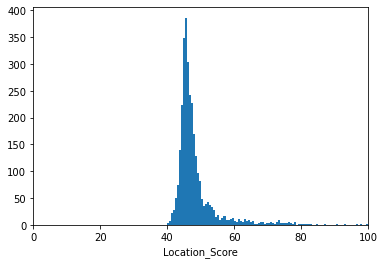

In [36]:
def get_result(cluster_data, Final_cluster):
    # Add the position to the distance data to display the counties
    position = ['State', 'County',  'MF_exist']
    cluster_data[position] = Final_cluster[position]
    cluster_data['FIPS'] = data['FIPS']

    Final_distance = cluster_data[['FIPS', 'State', 'County', 'MF_exist', 'location_score']].sort_values(by = 'location_score', ascending=False)
    #Final_distance.to_csv('../data/Final_dsitance.csv')
    # The first rank county has a high value, so we need to adjust the rest counties's score to balance the dataset
    adjust = 40
    cluster_data['location_score'] = cluster_data['location_score'] + adjust

    value = cluster_data.loc[cluster_data['location_score'].idxmax()]['location_score']- adjust
    cluster_data.loc[cluster_data['location_score'].idxmax(), ['location_score']] = value
    # Plot the figure
    plt.hist(cluster_data['location_score'], bins=100)
    plt.xlim((0, 100))
    plt.xlabel('Location_Score')
    plt.savefig('location_score.jpg', dpi=600)
    plt.show()
    # Add the position to the distance data to display the counties
    position = ['State', 'County',  'MF_exist']
    cluster_data[position] = Final_cluster[position]
    cluster_data['FIPS'] = data['FIPS']

    Final_distance = cluster_data[['FIPS', 'State', 'County', 'MF_exist', 'location_score']].sort_values(by = 'location_score', ascending=False)
    Final_distance.to_csv('../data/Final_dsitance.csv')
    # Combine the cluster and distance data to display the coexisting counties
    Combine_data = Final_distance.copy()
    Combine_data['Clusters'] = Final_cluster['Clusters']
    return Final_distance, Combine_data
Final_distance, Combine_data = get_result(cluster_data, Final_cluster)

AttributeError: 'PandasArray' object has no attribute '_str_startswith'

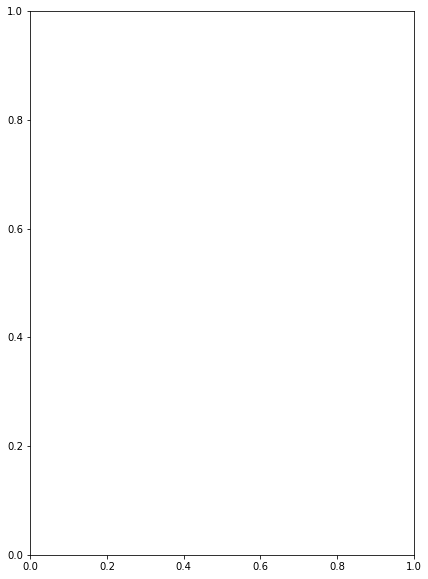

In [37]:
def merge_n_geopandas(Combine_data):
    location = pd.read_csv('../data/UsZipsList.csv')
    potential = pd.merge(Combine_data, location[['county_fips','lat','lng']], how='left', left_on='FIPS', right_on='county_fips').drop_duplicates(subset='FIPS')
    potential = potential.drop(columns='county_fips')
    potential['nm_MF'] = data['nm_MF']
    potential['num_competitor'] = data['num_competitor']
    potential = potential.fillna(0)
    avg = potential.loc[(potential.MF_exist == 1),'location_score'].mean()
    # The result displays the counties without MF and have a score higher than the average value
    Final_result = potential[(potential['Clusters'] != 0) & (potential['MF_exist'] == 0) & (potential['location_score'] > 72)]
    
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    us_map = world[world.name == 'United States of America']
    us_map.plot(alpha = 0.2, figsize=(10, 10))

    c = [n for n in Final_result["location_score"]]

    plt.scatter(data=Final_result, x='lng' ,y='lat' ,c=c, cmap='YlGn', s=100, alpha = 0.6)
    plt.colorbar(orientation="horizontal")
    plt.title('Potential opening locations')
    plt.xlim(-130, -65)
    plt.ylim(23, 52)

    plt.savefig('Potential.jpg', dpi=600)

    plt.style.use('ggplot')
    plt.show()
merge_n_geopandas(Combine_data)